In [1]:
import os
import sys
import math
import torch
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt

In [2]:
datasets_dir = os.path.join("/homeLocal/jpulzdeoliveira/datasets")
pastis_dir = os.path.join(datasets_dir, "PASTIS")
pastis_code_dir = os.path.join(datasets_dir, "PASTIS-benchmark/code")
sys.path.append(pastis_code_dir)

In [3]:
backend_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {backend_device} as backend device")

Using cuda as backend device


In [4]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [6]:
import geopandas as gpd
import json
from torch.utils.data import Dataset, random_split

def pre_load_data(root, split=0.95):
    print("Reading patch metadata...")
    meta_patch = gpd.read_file(os.path.join(root, "metadata.geojson"))
    meta_patch.index = meta_patch.ID_PATCH.astype(int)
    meta_patch.sort_index(inplace=True)

    print("Calculating normalization...")
    data_root = os.path.join(root, "DATA_S2")
    with open(os.path.join(root, "NORM_S2_patch.json"), 'r') as file:
        normvals = json.loads(file.read())
        folds = range(1, 6)
        means = [normvals[f"Fold_{f}"]["mean"] for f in folds]
        stds = [normvals[f"Fold_{f}"]["std"] for f in folds]
        mean = np.stack(means).mean(axis=0)
        mean = torch.from_numpy(mean).to(torch.float32)
        std = np.stack(stds).mean(axis=0)
        std = torch.from_numpy(std).to(torch.float32)
    
    print("Done.")

    split = int(len(meta_patch) * split)
    df1 = meta_patch.iloc[:split]
    df2 = meta_patch.iloc[split:]

    return (df1, df2,), (mean, std,)

class PASTISDatasetSemanticMedian(Dataset):
    def __init__(
        self,
        root,
        df,
        norm,
        num_timestamps=3,
        sampled_count=3,
        transforms=["vflip", "hflip", "rot"],
        mode="first",
        ):
        self.root = root
        self.data_root = os.path.join(root, "DATA_S2")
        self.meta_patch = df
        self.num_timestamps = num_timestamps
        self.sampled_count = sampled_count
        self.transforms = transforms
        self.mode = mode
        self.mean = norm[0]
        self.std = norm[1]

        print("Gathering patch counts...")
        self.patch_files = [] # Patch filenames
        self.selected_timestamps = [] # Num_patches*num_timestamps x sampled_count
        num_sampled = num_timestamps * sampled_count
        for patch in self.meta_patch.ID_PATCH:
            self.patch_files.append(patch)
            length = len(self.meta_patch.loc[patch]["dates-S2"])
            assert num_sampled <= length, \
                f"Number of samples {num_sampled} is bigger than number of patch timestamps {length}"
            if mode == "sampled":
                samples = np.arange(length)
                np.random.shuffle(samples)
                samples = samples[:num_sampled]
                self.selected_timestamps.extend(
                    samples.reshape((num_timestamps, sampled_count))
                    )
        self.len = len(self.patch_files) * num_timestamps

        print("Done.")
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        patch = self.patch_files[index // self.num_timestamps]
        
        data = np.load(os.path.join(self.data_root, f"S2_{patch}.npy")).astype(np.float32)
        target = np.load(os.path.join(self.root, "ANNOTATIONS", f"TARGET_{patch}.npy"))

        if self.mode == "sampled":
            selected_indexes = self.selected_timestamps[index]
        elif self.mode == "random":
            samples = np.arange(data.shape[0])
            np.random.shuffle(samples)
            selected_indexes = samples[:self.sampled_count]
        elif self.mode == "first":
            offset = index % self.num_timestamps
            selected_indexes = np.arange(self.sampled_count) + offset * self.sampled_count
        data = data[selected_indexes]
        target = target[0].astype(int)
        data, target = self.augment(data, target)

        data = np.median(data, axis=0)
        data = torch.from_numpy(data)
        data = self.normalize_data(data)
        target = torch.from_numpy(target)

        return data, target

    def augment(self, data, target):
        if "hflip" in self.transforms:
            p = np.random.random_sample()
            if p > 0.5:
                data = np.flip(data, 3)
                target = np.flip(target, 1)
        if "vflip" in self.transforms:
            p = np.random.random_sample()
            if p > 0.5:
                data = np.flip(data, 2)
                target = np.flip(target, 0)
        if "rot" in self.transforms:
            rot = np.random.randint(4)
            if rot > 0:
                data = np.rot90(data, k=rot, axes=(2, 3))
                target = np.rot90(target, k=rot, axes=(0, 1))

        return (np.ascontiguousarray(data), np.ascontiguousarray(target))
    
    def normalize_data(self, data):
        return (data - self.mean[:, None, None]) / self.std[:, None, None]

class PASTISDatasetSemanticPacked(Dataset):
    def __init__(
        self,
        root,
        df,
        norm,
        pack_timestamps=1,
        mode="first" # sampled, random, first
        ):
        self.root = root
        self.data_root = os.path.join(root, "DATA_S2")
        self.meta_patch = df
        self.pack_timestamps = pack_timestamps
        self.mode = mode
        self.mean = norm[0]
        self.std = norm[1]

        print("Gathering patch counts...")
        self.patch_files = [] # Patch filenames
        self.selected_timestamps = []
        for patch in self.meta_patch.ID_PATCH:
            self.patch_files.append(patch)
            if mode == "sampled":
                length = len(self.meta_patch.loc[patch]["dates-S2"])
                self.selected_timestamps.append(np.random.randint(0, length, pack_timestamps))
        
        print("Done.")

    def __len__(self):
        return len(self.patch_files)
    
    def __getitem__(self, index):
        patch = self.patch_files[index]
        
        data = np.load(os.path.join(self.data_root, f"S2_{patch}.npy")).astype(np.float32)
        target = np.load(os.path.join(self.root, "ANNOTATIONS", f"TARGET_{patch}.npy"))

        if self.mode == "sampled":
            selected_indexes = self.selected_timestamps[index]
        elif self.mode == "random":
            selected_indexes = np.random.randint(0, data.shape[0], self.pack_timestamps)
        elif self.mode == "first":
            selected_indexes = range(self.pack_timestamps)
        data = data[selected_indexes]
        target = target[0].astype(int)
        
        data = torch.from_numpy(data)
        data = self.normalize_data(data)
        data = data.view(-1, data.shape[2], data.shape[3])
        target = torch.from_numpy(target)

        return data, target

    def normalize_data(self, data):
        return (data - self.mean[None, :, None, None]) / self.std[None, :, None, None]

def augment(data, target, transforms=['hflip', 'vflip', 'rot']):
    if 'hflip' in transforms:
        p = np.random.random_sample()
        if p >= 0.5:
            data = torch.flip(data, (3,))
            target = torch.flip(target, (2,))
    if 'vflip' in transforms:
        p = np.random.random_sample()
        if p >= 0.5:
            data = torch.flip(data, (2,))
            target = torch.flip(target, (1,))
    if "rot" in transforms:
        rot = np.random.randint(4)
        if rot > 0:
            data = torch.rot90(data, k=rot, dims=(2, 3,))
            target = torch.rot90(target, k=rot, dims=(1, 2))

    return data, target

def get_median(data, count, interval, step=0):
    timestamps = data.size(1) // 10
    length = (interval + step) * count - step

    indexes = torch.arange(length + step)
    indexes = indexes.view(count, interval + step)
    indexes  = indexes[:, :interval]
    data = data.view(data.size(0), timestamps, 10, data.size(-2), data.size(-1))
    data = data[:, indexes]
    data = data.median(1).values
    return data

Reading patch metadata...


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Calculating normalization...
Done.

Train dataset
Gathering patch counts...
Done.
Dataset len: 16177


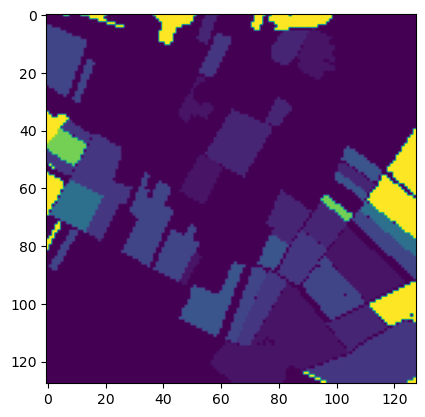

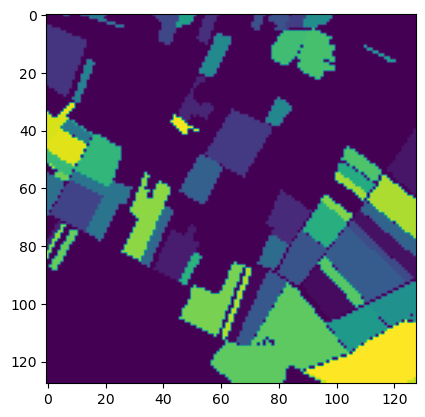

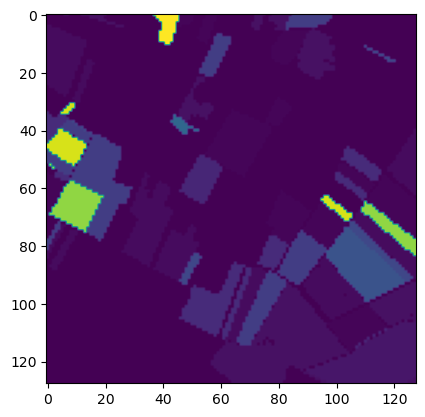

torch.Size([10, 128, 128])
torch.Size([128, 128])

Val dataset
Gathering patch counts...
Done.
Dataset len: 122
torch.Size([320, 128, 128])
torch.Size([128, 128])


In [7]:
(df1, df2), norm = pre_load_data(pastis_dir)

print("\nTrain dataset")
num_timestamps = 7
dataset = PASTISDatasetSemanticMedian(
    pastis_dir,
    df1,
    norm,
    num_timestamps=num_timestamps,
    sampled_count=5,
    mode="first"
    )
num_classes = 20
dataset_len = len(dataset)
print(f"Dataset len: {dataset_len}")
x, y = dataset[np.random.randint(dataset_len)]
print(x.shape)
print(y.shape)

print("\nVal dataset")
dataset_val = PASTISDatasetSemanticPacked(
    pastis_dir,
    df2,
    norm,
    pack_timestamps=32,
    mode="first"
    )
dataset_len = len(dataset_val)
print(f"Dataset len: {dataset_len}")
x, y = dataset_val[np.random.randint(dataset_len)]
print(x.shape)
print(y.shape)

In [7]:
from matplotlib.colors import ListedColormap

cm = mtp.colormaps["tab20"]
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1, 20)] + ['w']
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)

def get_input_rgb(x):
    im = x[[2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def plot_test(x, y):
    fix, axes = plt.subplots(1, 2, figsize=(20, 20))
    axes[0].imshow(get_input_rgb(x))
    axes[1].imshow(y.squeeze(), cmap=cmap, vmin=0, vmax=20)

#x, y, tmp = dataset[np.random.randint(dataset_len)]
#fix, axes = plt.subplots(1, dataset.sampled_count, figsize=(20, 20))
#for i in range(dataset.sampled_count):
#    t = torch.from_numpy(tmp[i])
#    axes[i].imshow(get_input_rgb(t))
#plt.show()
#plot_test(x, y)
#plt.show()

#x, y = dataset_val[np.random.randint(dataset_len)]
#x = x.unsqueeze(0)
#y = y.unsqueeze(0)
#med_count = 3
#x = get_median(x, med_count, 3, 1)
#fixa, axesa = plt.subplots(2, med_count, figsize=(med_count * 3, 6))
#fixb, axesb = plt.subplots(2, med_count, figsize=(med_count * 3, 6))
#for i in range(med_count):
#    img = x[:, i]
#    target = y.squeeze(0)
#    axesa[0, i].imshow(get_input_rgb(img.squeeze(0)))
#    axesa[0, i].axis('off')
#    axesa[1, i].imshow(target, cmap=cmap, vmin=0, vmax=20)
#    axesa[1, i].axis('off')

#    target = y
#    img, target = augment(img, target)
#    axesb[0, i].imshow(get_input_rgb(img[0]))
#    axesb[0, i].axis('off')
#    axesb[1, i].imshow(target[0], cmap=cmap, vmin=0, vmax=20)
#    axesb[1, i].axis('off')
    
#plt.show()

In [8]:
import multiprocessing
from torch.utils.data import DataLoader

test_split = 0.0475
n_data = len(dataset)
n_test = int(test_split * n_data)
n_train = n_data - n_test

train_set, test_set = random_split(dataset, [n_train, n_test])

batch_size = 8
num_workers = multiprocessing.cpu_count() * 2 // 5
pastis_dataloader = {
    'train': DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    ),
    'test': DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    ),
    'val': DataLoader(
        dataset_val,
        batch_size=32,
        shuffle=False,
        num_workers=num_workers
    )
}

In [9]:
def summarize(model):
    param_size = 0
    print(
        "====================================================================\n"
        " Parameter name                        | #          | Size\n"
        "--------------------------------------------------------------------"
        )
    for name, param in model.named_parameters():
        size = param.nelement() * param.element_size()
        print(f"{name:<38} | {param.numel():10d} | {size / 1048576:.2f}MB")
        param_size += size
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    print(
        "--------------------------------------------------------------------\n"
        f"Total size: {(param_size + buffer_size) / 1048576:.2f}MB\n"
        "===================================================================="
        )

In [10]:
%%script true
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

targets = []
for _, y in tqdm(pastis_dataloader['train'], desc="batches", leave=False, position=0):
    targets.extend(y.flatten().numpy())
    
#unique = np.bincount(targets)
#weights = len(targets) / (20 * unique)
#print(weights)

classes = np.arange(num_classes)
classes_weights = compute_class_weight(class_weight="balanced", classes=classes, y=targets)
classes_weights = torch.tensor(classes_weights, dtype=torch.float32)
classes_weights /= classes_weights.min()
print(classes_weights)

In [11]:
from models.ocrnet import HRNet_Mscale
from loss.utils import get_loss
from torch import nn

hrnet_model = HRNet_Mscale(10, 1, num_classes, get_loss(num_classes)[0], crf=True)
summarize(hrnet_model)

Using Cross Entropy Loss
Trunk: hrnetv2
 Parameter name                        | #          | Size
--------------------------------------------------------------------
backbone.conv1.weight                  |       5760 | 0.02MB
backbone.bn1.weight                    |         64 | 0.00MB
backbone.bn1.bias                      |         64 | 0.00MB
backbone.conv2.weight                  |      36864 | 0.14MB
backbone.bn2.weight                    |         64 | 0.00MB
backbone.bn2.bias                      |         64 | 0.00MB
backbone.layer1.0.conv1.weight         |       4096 | 0.02MB
backbone.layer1.0.bn1.weight           |         64 | 0.00MB
backbone.layer1.0.bn1.bias             |         64 | 0.00MB
backbone.layer1.0.conv2.weight         |      36864 | 0.14MB
backbone.layer1.0.bn2.weight           |         64 | 0.00MB
backbone.layer1.0.bn2.bias             |         64 | 0.00MB
backbone.layer1.0.conv3.weight         |      16384 | 0.06MB
backbone.layer1.0.bn3.weight           

In [12]:
import signal
from abc import ABC, abstractmethod
from datetime import datetime
from sklearn.metrics import cohen_kappa_score, f1_score, jaccard_score
from torch import optim
from tqdm import tqdm

class AveragePerBatchMetric():
    def __init__(self, criteria):
        self.criteria = criteria
        self.values = []
    
    @abstractmethod
    def append(self, y_hat, y):
        pass

    @abstractmethod
    def get(self):
        mean = np.mean(self.values)
        self.values = []
        return mean

stop = False
def handler(sig, frame):
    global stop
    if not stop:
        print("stopping next training iteration")
    stop = True

def stop_callback():
    signal.signal(signal.SIGINT, handler)

def train_one_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device,
    use_amp,
    max_norm
    ):
    model.train()
    start_time = datetime.now()

    scaler = torch.cuda.amp.GradScaler()
    losses = []
    for x, y in tqdm(dataloader, desc="train batches", leave=False, position=0):
        if device is not None:
            x = x.to(device)
            y = y.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            _, _, loss = model({ 'images': x, 'gts': y })
            #loss = loss_fn(y_hat, y)

        loss_val = loss.item()
        losses.append(loss_val)
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
            
        optimizer.zero_grad(set_to_none=True)
    
    end_time = datetime.now()
    timespan = end_time - start_time

    return (timespan, losses)

@torch.no_grad
def test_one_epoch(model, dataloader, loss_fn, metrics, device):
    model.eval()
    start_time = datetime.now()

    losses = []
    for x, y in tqdm(dataloader, desc="test batches", leave=False, position=0):
        if device is not None:
            x = x.to(device)
            y = y.to(device)
        
        y_hat = model({ 'images': x, 'gts': y })

        loss = loss_fn(y_hat['pred'], y)
        losses.append(loss.item())
        
        for key in metrics:
            metrics[key].append(y_hat['pred'], y)
    
    end_time = datetime.now()
    timespan = end_time - start_time

    return (timespan, losses)

def train(
    model,
    dataloader,
    loss_fn,
    optimizer,
    scheduler,
    metrics,
    device,
    epochs,
    test_interval=4,
    checkpoints=5,
    checkpoints_dir=None,
    report_interval=1,
    use_amp=True,
    max_norm=0.1
    ):
    metrics_history = {
        'train': {},
        'test': {
            key: ([]) for key in metrics['test']
        }
    }
    metrics_history['train']['loss'] = []
    metrics_history['test']['loss'] = []

    def save_checkpoint(epoch, model, optimizer, checkpoints_dir=None):
        checkpoint_path = f"checkpoint_pastis.pth"
        if checkpoints_dir is not None:
            checkpoint_path = os.path.join(checkpoints_dir, checkpoint_path)
        print(f"saving checkpoint {checkpoint_path}")
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            checkpoint_path
            )

    model.to(device)
    for epoch in range(1, epochs + 1):
        if stop:
            break

        timespan, losses = train_one_epoch(
            model,
            dataloader['train'],
            loss_fn,
            optimizer,
            device,
            use_amp,
            max_norm
        )
        print(
            f"==============================================\n"
            f"EPOCH {epoch:4d}\n"
            "train results:"
            )
        tloss = np.mean(losses)
        metrics_history['train']['loss'].append(tloss)
        print(
            f"\ttimespan: {timespan}\n"
            f"\tloss: {tloss:.4f}"
            )

        if epoch % test_interval == 0:
            timespan, losses = test_one_epoch(
                model,
                dataloader['test'],
                loss_fn,
                metrics['test'],
                device
                )
            vloss = np.mean(losses)
            metrics_history['test']['loss'].append(vloss)
            print(
                "test results:\n"
                f"\ttimespan: {timespan}\n"
                f"\tloss: {np.mean(losses):.4f}"
                )
            for key in metrics['test']:
                score = metrics['test'][key].get()
                metrics_history['test'][key].append(score)
                print(f"\t{key}: {score:.4f}")

        scheduler.step()

        if checkpoints is not None and epoch % checkpoints == 0:
            save_checkpoint(epoch, model, optimizer, checkpoints_dir)

    return metrics_history

In [13]:
class AverageJaccard(AveragePerBatchMetric):
    def __init__(self):
        super().__init__(jaccard_score)

    def append(self, y_hat, y):
        target = y.flatten().cpu().to(torch.long).numpy()
        y_hat = torch.argmax(y_hat, dim=1)
        pred = y_hat.flatten().cpu().to(torch.long).numpy()
        acc = self.criteria(target, pred, average='macro')
        self.values.append(acc)

class AverageF1Score(AveragePerBatchMetric):
    def __init__(self):
        super().__init__(f1_score)

    def append(self, y_hat, y):
        target = y.flatten().cpu().to(torch.long).numpy()
        y_hat = torch.argmax(y_hat, dim=1)
        pred = y_hat.flatten().cpu().to(torch.long).numpy()
        acc = self.criteria(target, pred, average='macro')
        self.values.append(acc)

class AverageCohenKappa(AveragePerBatchMetric):
    def __init__(self):
        super().__init__(cohen_kappa_score)

    def append(self, y_hat, y):
        target = y.flatten().cpu().to(torch.long).numpy()
        y_hat = torch.argmax(y_hat, dim=1)
        pred = y_hat.flatten().cpu().to(torch.long).numpy()
        acc = self.criteria(target, pred)
        self.values.append(acc)

In [15]:
import warnings

stop_callback()

#torch.autograd.set_detect_anomaly(True)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.benchmark = True

loss_fn = nn.CrossEntropyLoss(
    weight=classes_weights.to(backend_device)
    )
optimizer = optim.Adam(params=hrnet_model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
#scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=60, power=2.0)
# TEST: PolynomialLR(optimizer, total_iters=4, power=1.0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.891251)
metrics = {
    #'train': { 'jaccard': AverageJaccard(), 'f1_score': AverageF1Score(), 'cohen_kappa': AverageCohenKappa() },
    'test': {
        'jaccard': AverageJaccard(),
        'f1_score': AverageF1Score(),
        'cohen_kappa': AverageCohenKappa()
    }
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = train(
        hrnet_model,
        pastis_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        metrics,
        backend_device,
        60,
        checkpoints=10,
        report_interval=1
        )

EPOCH    1
train results:
EPOCH    2
train results:
EPOCH    3
train results:
EPOCH    4
train results:


KeyboardInterrupt: 

In [16]:
model_save_path = os.path.join("/homeLocal/jpulzdeoliveira/models/PASTIS-hrnet.pth")
torch.save(hrnet_model.state_dict(), model_save_path)

In [15]:
model_save_path = os.path.join("/homeLocal/jpulzdeoliveira/models/PASTIS-hrnet.pth")
hrnet_model.load_state_dict(torch.load(model_save_path))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
from matplotlib.colors import ListedColormap

cm = mtp.colormaps["tab20"]
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1, 20)] + ['w']
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)

def get_input_rgb(x):
    im = x[[2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def plot_test(x, y, y_hat):
    fix, axes = plt.subplots(1, 3, figsize=(20, 20))
    axes[0].imshow(get_input_rgb(x))
    axes[1].imshow(y.squeeze(), cmap=cmap, vmin=0, vmax=20)
    axes[2].imshow(y_hat.squeeze(), cmap=cmap, vmin=0, vmax=20)

tx, ty = dataset[np.random.randint(len(dataset))]

hrnet_model.to("cpu")

#!cd test_results && rm -rf plot-*
test_results_dir = os.path.join("./", "test_results")
hrnet_model.eval()
jaccard = AverageJaccard()
ranges = (
    (3, 3, 0),
    (3, 3, 1),
    (3, 3, 2),
    (5, 3, 0),
    (5, 3, 1),
    (5, 3, 2),
)
accuracies = []
with torch.no_grad():
    for x, y in tqdm(
        pastis_dataloader['val'],
        leave=False,
        position=0
        ):
        for c, i, s in ranges:
            mx = get_median(x, c, i, s)
            for j in range(mx.size(0)):
                for k in range(mx.size(1)):
                    tx = mx[j:j+1, k]
                    ty = y[j:j+1]
                    tx, ty = augment(tx, ty)
                    ty_hat = hrnet_model({'images': tx, 'gts': ty})
                    ty_hat = ty_hat['pred']
                    jaccard.append(ty_hat, ty)
                    ty_hat = torch.argmax(ty_hat, dim=1).squeeze(0).detach()

                    plt.figure(num=1, clear=True)
                    plot_test(tx.squeeze(0), ty.squeeze(0), ty_hat)
                    acc = jaccard.get()
                    accuracies.append(acc)
                    plt.title(acc)
                    plt.savefig(os.path.join(
                        test_results_dir,
                        f"plot-{acc * 10:.2f}{i * x.size(0) + j}.png"
                        ), bbox_inches='tight')
                    #plt.show()
                    plt.close("all")
                    plt.close()

print(f"\nvalidation average accuracy: {np.mean(accuracies)}")

 50%|██████████████████████████████████████████                                          | 2/4 [26:39<26:34, 797.37s/it]